In [1]:
# Magic Words
from __future__ import annotations
from typing import Dict, Any
import os
import subprocess

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.image import AxesImage
from PIL import Image

%matplotlib inline

## Sample Image

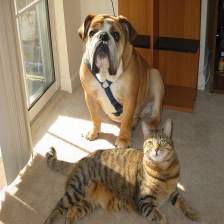

In [2]:
# The famous image of both dog and cat often used in CAM papers
url: str = (
    "https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/"
    "master/examples/both.png"
)
path: str = "both.png"
if not os.path.exists(path):
    subprocess.run(["wget", "-q", "-O", path, url])
Image.open(path)

## Sample Configurations of Matplotlib

In [3]:
figsize: float = 2.24  # 224 pixel -> 100 dpi * 2.24 inch
fontsize: float = 10.0
rc: Dict[str, Any] = {
    "font.family": "Noto Sans JP",
    "font.size": fontsize,
    "figure.titlesize": fontsize * 1.4,
    "xtick.labelsize": fontsize * 0.6,
    "ytick.labelsize": fontsize * 0.6,
    "axes.linewidth": 0.2,
    "xtick.major.size": 2.0,
    "xtick.major.width": 0.2,
    "ytick.major.size": 2.0,
    "ytick.major.width": 0.2,
}

# CAM (Class Activation Mapping)

In [4]:
from cam import CAM

## Supported TorchVision pre-Trained CNN Classifiers

In [5]:
CAM.show_cnn_models()

* MobileNetV3Small
* MobileNetV3Large
* VGG11
* VGG13
* VGG16
* VGG19
* ResNet18
* ResNet34
* ResNet50
* ResNet101
* ResNet152
* ResNeXt50_32X4D
* ResNeXt101_32X8D
* ResNeXt101_64X4D
* WideResNet50_2
* WideResNet101_2

## Implemented CAM Models

In [6]:
CAM.show_cam_models()

* Dummy-CAM
* Fake-CAM
* CAM
* Grad-CAM
* Grad-CAM++
* SmoothGrad-CAM++
* InteGrad-CAM
* XGrad-CAM
* HiRes-CAM
* Eigen-CAM
* EigenGrad-CAM
* Ablation-CAM
* Score-CAM
* Group-CAM
* Cluster-CAM
* Cosine-CAM
* Poly-CAM
* Base-CAM
* LIME

## Create CAM Instance

In [7]:
cam: CAM = CAM(
    cnn_model="MobileNetV3Large",
    cam_model="Grad-CAM",
    n_channels=16,  # effective in Score-CAM, Group-CAM, Cluster-CAM and Cosine-CAM
    n_groups=14,  # effective in Group-CAM, Cluster-CAM and Cosine-CAM
    random_state=12,
)

* `n_channels` : The number of channel (group)s to calculate the CIC score.
    * -1 == "all channels" (very very slow.)
* `n_groups`: The number of groups of channels in clustering methods (k-Means, Spectral Clustering).
    * None == automatically detect the optimal number of groups inside the Library
        * detect based on the elbow point of inertias in k-Means.
        * very slow.

In [8]:
## You can create the instance of each CAM model directly
from cam.backbones import backbone_mobilenet_v3_large
from cam.models import GradCAM


gradcam: GradCAM = GradCAM(
    backbone=backbone_mobilenet_v3_large,
    random_state=12,
)

## Show Convolutional Layers

In [9]:
cam.show_conv_layers()

|   block | shape        | is_last   | offset   | name                  |
|--------:|:-------------|:----------|:---------|:----------------------|
|       1 | 1x16x112x112 | True      | 0        | features.1.block.1.0  |
|       2 | 1x24x56x56   | False     |          | features.2.block.2.0  |
|       3 | 1x24x56x56   | True      | 1        | features.3.block.2.0  |
|       4 | 1x40x28x28   | False     |          | features.4.block.3.0  |
|       5 | 1x40x28x28   | False     |          | features.5.block.3.0  |
|       6 | 1x40x28x28   | True      | 2        | features.6.block.3.0  |
|       7 | 1x80x14x14   | False     |          | features.7.block.2.0  |
|       8 | 1x80x14x14   | False     |          | features.8.block.2.0  |
|       9 | 1x80x14x14   | False     |          | features.9.block.2.0  |
|      10 | 1x80x14x14   | False     |          | features.10.block.2.0 |
|      11 | 1x112x14x14  | False     |          | features.11.block.3.0 |
|      12 | 1x112x14x14  | True      | 3        | features.12.block.3.0 |
|      13 | 1x160x7x7    | False     |          | features.13.block.3.0 |
|      14 | 1x160x7x7    | False     |          | features.14.block.3.0 |
|      15 | 1x160x7x7    | False     |          | features.15.block.3.0 |
|      16 | 1x960x7x7    | True      | 4        | features.16.0         |

## Indicate the Target Convolutional Layer

In [10]:
from cam.base import TargetLayer


## You can indicate the target using specified word ("last" or "all").
target: TargetLayer = "last"  # features.16.0
# features.1..., features.3..., features.6..., features.12... & features.16.0
# target: TargetLayer = "all"

## And you can indicate using a integer (offset).
# target: TargetLayer = 3  # features.12...
# target: TargetLayer = -2  # features.12...

## And you can indicate targets as list of integers.
# target: TargetLayer = [3, 4]  # features.12... & features.16.0
# target: TargetLayer = [-1, -2]  # features.12... & features.16.0

## Indicate the Target Label of Rank

In [11]:
## indicate the label directly
label: Optional[int] = 243  # bull mastiff
rank: Optional[int] = None  # dummy

## or you can indicate by rank.
# label: Optional[int] = None
# rank: Optional[int] = 0  # the label of top rank

## If both the label and the rank are None, handle as rank = 0.
## Both the the label and the rank are indicated (not None), use the label only.

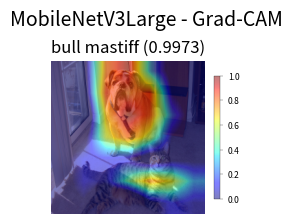

In [12]:
with plt.rc_context(rc=rc):
    fig, ax = plt.subplots(figsize=(figsize, figsize))
    # draw heatmap and create colorbar
    colorbar: AxesImage = cam.draw(
        path="both.png",
        target=target,
        label=label,
        rank=rank,
        ax=ax,
        ## Parameters of draw()
        # draw negative region or not (default: False)
        draw_negative=False,
        # add your own title (default: None)
        title=None,
        # if title == None, add CAM model name to the title (default: False)
        title_model=False,
        # if title == None, add label name to the title (defalut: False)
        title_label=True,
        # if title == None, add score to the title (default: False)
        title_score=True,
    )
    # draw colorbar
    fig.colorbar(colorbar, ax=ax, shrink=0.8)
    # draw suptitle
    fig.suptitle(f"{cam.cnn_model} - {cam.cam_model}")
    fig.tight_layout()
    plt.show()
    plt.clf()
    plt.close()

# Create Your Own CAM Model

You can create your own CAM Model by combinating various elements

In [13]:
original_cam: CAM = CAM(
    cnn_model="MobileNetV3Large",
    cam_model="Base-CAM",  # Basis of CAM Model
    ## Settings for CAM model
    ## how to use the gradient
    # activation_weight="none",  # don't use Gradient (default)
    # activation_weight="fake",  # Fake-CAM
    # activation_weight="class",  # CAM
    # activation_weight="gradient",  # Grad-CAM
    # activation_weigth="gradient++",  # Grad-CAM++
    activation_weight="axiom",  # XGrad-CAM
    ## how to smooth the gradient
    # gradient_smooth="none",  # do nothing (default)
    # gradient_smooth="noise",  # SmoothGrad
    # gradient_smooth="integral",  # IntegratedGrads
    gradient_smooth="noise+integral",  # SmoothGrad + IntegratedGrads
    ## average the gradient over position or not
    # gradient_no_gap=False,  # average the gradient over position (default)
    gradient_no_gap=True,  # HiRes-CAM (don't average)
    ## how to weight for each channel (group)s
    # channel_weight="none",  # simple mean (default)
    # channel_weight="eigen",  # Eigen-CAM
    # channel_weight="ablation",  # Ablation-CAM
    channel_weight="abscission",  # Score-CAM
    ## how to cluster channels
    # channel_group="none",  # don't cluster channels (default)
    # channel_group="k-means",  # clustering using k-Means
    channel_group="spectral",  # clustering using Spectral Clustering
    ## normalize before clustering or not
    # channel_cosine=False,  # don't normalize (default)
    channel_cosine=True,  # normalize (original implementation)
    ## use cognition-base and cognition-scissors or not
    # channel_minmax=False,  # don't use cognition-base/scissors (default)
    channel_minmax=True,  # use cognition-base/scissors (Cluster-CAM)
    ## normalize CIC scores using softmax or not
    # normalize_softmax=False,  # normalize to L2-norm == 1 (default)
    normalize_softmax=True,  # normalize using softmax (Score-CAM)
    ## use higher Convolutional Layer as high-resolutionalize mask or not
    # high_resolution=False,  # just add layers (default)
    high_resolution=True,  # Poly-CAM
    ## Parameters
    batch_size=8,  # max number of activations to forward in a batch (Ablation-CAM)
    n_divides=8,  # number of divides to integral (IntegratedGrads)
    n_samples=8,  # number of noised images (SmoothGrad)
    sigma=0.3,  # standard deviation (SmoothGrad)
    n_channels=-1,  # use all channel groups
    n_groups=None,  # auto detect
    random_state=12,
)

In [14]:
# set the name of your own CAM Model
original_cam.set_cam_name("Original CAM")

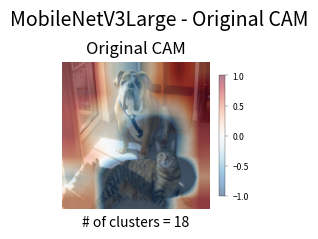

In [15]:
with plt.rc_context(rc=rc):
    fig, ax = plt.subplots(figsize=(figsize, figsize))
    # draw heatmap and create colorbar
    colorbar: AxesImage = original_cam.draw(
        path="both.png",
        target=target,
        label=label,
        rank=rank,
        ax=ax,
        ## Parameters of draw()
        # draw negative region or not (default: False)
        draw_negative=True,
        # add your own title (default: None)
        title=None,
        # if title == None, add CAM model name to the title (default: False)
        title_model=True,
        # if title == None, add label name to the title (defalut: False)
        title_label=False,
        # if title == None, add score to the title (default: False)
        title_score=False,
    )
    # draw colorbar
    fig.colorbar(colorbar, ax=ax, shrink=0.8)
    # draw suptitle
    fig.suptitle(f"{original_cam.cnn_model} - {original_cam.cam_model}")
    fig.tight_layout()
    plt.show()
    plt.clf()
    plt.close()

# CLI

In [16]:
!python -m cam --help

usage: __main__.py [-h] --cnn-model
                   {MobileNetV3Small,MobileNetV3Large,VGG11,VGG13,VGG16,VGG19,ResNet18,ResNet34,ResNet50,ResNet101,ResNet152,ResNeXt50_32X4D,ResNeXt101_32X8D,ResNeXt101_64X4D,WideResNet50_2,WideResNet101_2}
                   --cam-model
                   {Dummy-CAM,Fake-CAM,CAM,Grad-CAM,Grad-CAM++,SmoothGrad-CAM++,InteGrad-CAM,XGrad-CAM,HiRes-CAM,Eigen-CAM,EigenGrad-CAM,Ablation-CAM,Score-CAM,Group-CAM,Cluster-CAM,Cosine-CAM,Poly-CAM,Base-CAM,LIME}
                   --path PATH --target TARGET [--rank RANK] [--label LABEL]
                   [--top-labels TOP_LABELS] [--num-features NUM_FEATURES]
                   [--num-samples NUM_SAMPLES] [--batch-size BATCH_SIZE]
                   [--n-divides N_DIVIDES] [--n-samples N_SAMPLES]
                   [--sigma SIGMA]
                   [--activation-weight {none,fake,class,gradient,gradient++,axiom}]
                   [--gradient-smooth {none,noise,integral,noise+integral}]
                   [-

In [17]:
!python -m cam --path both.png --cnn-model MobileNetV3Large --cam-model Grad-CAM --target last --rank 0 --title-label --title-score --draw-negative --draw-colorbar --output heatmap_both.png

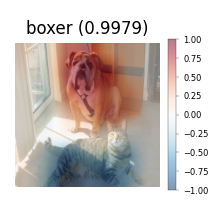

In [18]:
Image.open("heatmap_both.png")